# Translation Efficiency Prediction with OmniGenBench

This notebook demonstrates how to fine-tune a Genomic Foundation Model (GFM) to predict Rice translation efficiency (TE) from mRNA sequences using OmniGenBench. The example focusing on plant RNA translation efficiency.

**Background (PlantRNA-FM):**
PlantRNA-FM ("An interpretable RNA foundation model for exploring functional RNA motifs in plants") introduces an RNA foundation model tailored to plant genomics, highlighting interpretability and motif discovery capabilities. TE prediction is a representative downstream task where models learn sequence determinants associated with efficient translation. In this demo, we use a small rice RNA [`translation efficiency dataset`](https://huggingface.co/datasets/yangheng/translation_efficiency_prediction) to illustrate fine-tuning and evaluation within OmniGenBench.

- **Task type**: Binary sequence classification (High-TE vs Low-TE)
- **Input**: RNA sequences (string), up to a configurable `max_length`
- **Label space**: {0: Low-TE, 1: High-TE}

**Estimated runtime:** On a single NVIDIA RTX 4090, a short training run on this toy dataset typically takes ~10–30 minutes depending on epochs/model size.

##  Notebook Structure

This notebook is organized into concise sections. Most core logic is moved to [`examples/translation_efficiency_prediction/utils.py`](https://github.com/COLA-Laboratory/OmniGenBench/blob/master/examples/translation_efficiency_prediction/utils.py) and imported here:

1. **Setup & Installation**: Install optional dependencies.
2. **Import Libraries**: Load Python packages and local utilities.
3. **Configuration & Data**: Choose a model, set hyperparameters, and point to dataset files.
4. **Main Analysis Pipeline**: Run training/evaluation with `utils.run_training`.
5. **Results Overview**: Summarize validation/test metrics.
6. **Visualization**: Plot validation metrics across epochs.
7. **References**: Link to PlantRNA-FM.

## 1. Setup & Installation

This section handles the initial setup, including installing necessary packages. If dependencies are already available, you can skip the installation cell.

### Install Dependencies
Uncomment and run the following cell to install the required packages.

In [1]:
# Optional: install dependencies if not available
# !pip install torch transformers pandas autocuda multimolecule biopython scipy scikit-learn tqdm dill findfile requests omnigenbench


## 2. Import Libraries
Import all necessary libraries for data processing, model training, and analysis.

In [2]:
import warnings
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from autocuda import auto_cuda

# Import utilities from the local utils.py file
utils_spec = importlib.util.spec_from_file_location("utils", "utils.py")
utils = importlib.util.module_from_spec(utils_spec)
utils_spec.loader.exec_module(utils)

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")


C:\Users\hengu\miniconda3\envs\py312\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



    **@@ #========= @@**            ___                     _
      **@@ +----- @@**             / _ \  _ __ ___   _ __  (_)
        **@@ = @@**               | | | || '_ ` _ \ | '_ \ | |
           **@@                   | |_| || | | | | || | | || |
        @@** = **@@                \___/ |_| |_| |_||_| |_||_|
     @@** ------+ **@@
   @@** =========# **@@            ____
  @@ ---------------+ @@          / ___|  ___  _ __
 @@ ================== @@        | |  _  / _ \| '_ \
  @@ +--------------- @@         | |_| ||  __/| | | |
   @@** #========= **@@           \____| \___||_| |_|
    @@** +------ **@@
       @@** = **@@
          @@**                    ____                      _
       **@@ = @@**               | __ )   ___  _ __    ___ | |__
    **@@ -----+  @@**            |  _ \  / _ \| '_ \  / __|| '_ \
  **@@ ==========# @@**          | |_) ||  __/| | | || (__ | | | |
  @@ --------------+ @@**        |____/  \___||_| |_| \___||_| |_|

Libraries imported successfully!


## 3. Configuration & Data

Set up the analysis parameters, file paths, and model selection here. You can easily change the `MODEL_NAME` to test different GFMs.

### Model Selection
Choose the Genomic Foundation Model to fine-tune.

In [3]:
# Using utils for reusable logic
from utils import run_finetuning
print("Core classes and functions imported from utils.")

# --- Available Models for Testing ---
AVAILABLE_MODELS = [
    # 'yangheng/OmniGenome-52M',
    # 'yangheng/OmniGenome-186M',
    'yangheng/OmniGenome-v1.5',
]
MODEL_NAME = AVAILABLE_MODELS[0]  # Model to use for predictions
print(f"Selected model: {MODEL_NAME}")


Core classes and functions imported from utils.
Selected model: yangheng/OmniGenome-v1.5


### Hyperparameter and Dataset Configuration
Define the training hyperparameters and paths to the dataset files.

In [4]:
import findfile

# --- Training Hyperparameters ---
EPOCHS = 10
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 4
MAX_LENGTH = 1024
SEED = 42

# --- Dataset Configuration ---
LOCAL_PATH = "te_rice_dataset"  # Local directory for the dataset
from utils import download_te_dataset
download_te_dataset(LOCAL_PATH)  # Download the VEP dataset if not already available

# --- Dataset Configuration ---
TRAIN_FILE = findfile.find_cwd_file("train.json")  # training split
VALID_FILE = findfile.find_cwd_file("valid.json")  # validation split (optional)
TEST_FILE = findfile.find_cwd_file("test.json")  # test split
# --- Label Mapping ---
# The task is binary classification: 1 for TE, 0 for non-TE.
LABEL2ID = {"0": 0, "1": 1}

print(f"Selected model: {MODEL_NAME}")


Downloaded te_rice_dataset\te_rice_dataset.zip
Extracted te_rice_dataset.zip into te_rice_dataset
Selected model: yangheng/OmniGenome-v1.5


## 4. Main Analysis Pipeline

This section executes the training/evaluation pipeline using the configuration defined above. The `run_training` function from `examples/translation_efficiency_prediction/utils.py` orchestrates tokenization, dataset creation, training, and evaluation.

In [5]:
# Import main pipeline from utils for a concise demo
from utils import run_finetuning

print("Main analysis pipeline imported from utils.")

print("=" * 50)

# Run the analysis
metrics = run_finetuning(
	model_name=MODEL_NAME,
	train_file=TRAIN_FILE,
	valid_file=VALID_FILE,
	test_file=TEST_FILE,
	label2id=LABEL2ID,
	epochs=EPOCHS,
	learning_rate=LEARNING_RATE,
	weight_decay=WEIGHT_DECAY,
	batch_size=BATCH_SIZE,
	max_length=MAX_LENGTH,
	seed=SEED,
)

print("=" * 50)
print("Analysis completed!")

# Print final validation and test metrics (if available)
if metrics.get('valid'):
	print("\nValidation Set Performance (last epoch):")
	for key, value in metrics['valid'][-1].items():
		print(f"{key}: {value:.4f}")

if metrics.get('test'):
	print("\nTest Set Performance (best checkpoint):")
	for key, value in metrics['test'][-1].items():
		print(f"{key}: {value:.4f}")


Main analysis pipeline imported from utils.


Some weights of OmniGenomeModel were not initialized from the model checkpoint at yangheng/OmniGenome-v1.5 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[2025-09-11 16:14:35.027] [omnigenbench 0.3.11alpha2]  Model Name: OmniModelForSequenceClassification
Model Metadata: {'library_name': 'omnigenbench', 'omnigenbench_version': '0.3.11alpha2', 'torch_version': '2.8.0+cu129+cu12.9+gita1cb3cc05d46d198467bebbb6e8fba50a325d4e7', 'transformers_version': '4.56.1', 'model_cls': 'OmniModelForSequenceClassification', 'tokenizer_cls': 'EsmTokenizer', 'model_name': 'OmniModelForSequenceClassification'}
Base Model Name: yangheng/OmniGenome-v1.5
Model Type: omnigenome
Model Architecture: ['OmniGenomeForMaskedLM']
Model Parameters: 185.886801 M
Model Config: OmniGenomeConfig {
  "OmniGenomefold_config": null,
  "architectures": [
    "OmniGenomeForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auto_map": {
    "AutoConfig": "configuration_omnigenome.OmniGenomeConfig",
    "AutoModel": "modeling_omnigenome.OmniGenomeModel",
    "AutoModelForMaskedLM": "modeling_omnigenome.OmniGenomeForMaskedLM",
    "AutoModelForSeq2SeqLM": "modeling_omnigeno

100%|██████████| 4697/4697 [00:13<00:00, 350.50it/s]


[2025-09-11 16:14:48.508] [omnigenbench 0.3.11alpha2]  
Label Distribution:
[2025-09-11 16:14:48.508] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:48.510] [omnigenbench 0.3.11alpha2]  Label     		Count     		Percentage
[2025-09-11 16:14:48.514] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:48.515] [omnigenbench 0.3.11alpha2]  0         		2195      		46.73%
[2025-09-11 16:14:48.517] [omnigenbench 0.3.11alpha2]  1         		2502      		53.27%
[2025-09-11 16:14:48.520] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:48.522] [omnigenbench 0.3.11alpha2]  Total samples: 4697
[2025-09-11 16:14:48.592] [omnigenbench 0.3.11alpha2]  Max sequence length updated -> Reset max_length=504, label_padding_length=0
[2025-09-11 16:14:48.726] [omnigenbench 0.3.11alpha2]  Detected max_length=1024 in the dataset, using it as the max_length.
[2025-09-11 16:14:48.728] [omnigenbench 0.3.

100%|██████████| 587/587 [00:01<00:00, 353.29it/s]


[2025-09-11 16:14:50.417] [omnigenbench 0.3.11alpha2]  
Label Distribution:
[2025-09-11 16:14:50.418] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:50.421] [omnigenbench 0.3.11alpha2]  Label     		Count     		Percentage
[2025-09-11 16:14:50.423] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:50.425] [omnigenbench 0.3.11alpha2]  0         		259       		44.12%
[2025-09-11 16:14:50.427] [omnigenbench 0.3.11alpha2]  1         		328       		55.88%
[2025-09-11 16:14:50.429] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:50.430] [omnigenbench 0.3.11alpha2]  Total samples: 587
[2025-09-11 16:14:50.450] [omnigenbench 0.3.11alpha2]  Max sequence length updated -> Reset max_length=504, label_padding_length=0
[2025-09-11 16:14:50.469] [omnigenbench 0.3.11alpha2]  Detected max_length=1024 in the dataset, using it as the max_length.
[2025-09-11 16:14:50.471] [omnigenbench 0.3.1

100%|██████████| 588/588 [00:01<00:00, 443.00it/s]


[2025-09-11 16:14:51.822] [omnigenbench 0.3.11alpha2]  
Label Distribution:
[2025-09-11 16:14:51.824] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:51.826] [omnigenbench 0.3.11alpha2]  Label     		Count     		Percentage
[2025-09-11 16:14:51.829] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:51.830] [omnigenbench 0.3.11alpha2]  0         		258       		43.88%
[2025-09-11 16:14:51.833] [omnigenbench 0.3.11alpha2]  1         		330       		56.12%
[2025-09-11 16:14:51.835] [omnigenbench 0.3.11alpha2]  ----------------------------------------
[2025-09-11 16:14:51.838] [omnigenbench 0.3.11alpha2]  Total samples: 588
[2025-09-11 16:14:51.855] [omnigenbench 0.3.11alpha2]  Max sequence length updated -> Reset max_length=504, label_padding_length=0
Datasets and DataLoaders created.


Evaluating: 100%|██████████| 147/147 [00:11<00:00, 12.70it/s]


[2025-09-11 16:15:04.027] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.3095483894174565}


Evaluating: 100%|██████████| 147/147 [00:13<00:00, 10.72it/s]


[2025-09-11 16:20:12.989] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7414360934058721}


Evaluating: 100%|██████████| 147/147 [00:15<00:00,  9.61it/s]


[2025-09-11 16:25:29.445] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7209673907376569}


Evaluating: 100%|██████████| 147/147 [00:14<00:00, 10.26it/s]


[2025-09-11 16:31:11.643] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7425685350248176}


Evaluating: 100%|██████████| 147/147 [00:22<00:00,  6.42it/s]


[2025-09-11 16:38:07.833] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7396651129458136}


Evaluating: 100%|██████████| 147/147 [00:19<00:00,  7.43it/s]


[2025-09-11 16:44:48.893] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7299682167949146}


Evaluating: 100%|██████████| 147/147 [00:24<00:00,  5.89it/s]


[2025-09-11 16:51:07.439] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7325103836207272}


Evaluating: 100%|██████████| 147/147 [00:20<00:00,  7.12it/s]


[2025-09-11 16:57:50.337] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.6671706671706672}


Evaluating: 100%|██████████| 147/147 [00:22<00:00,  6.53it/s]


[2025-09-11 17:03:56.948] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.67966297912073}


Evaluating: 100%|██████████| 147/147 [00:11<00:00, 12.81it/s]


[2025-09-11 17:10:15.132] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7588886979168183}


Evaluating: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[2025-09-11 17:15:10.725] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7152533237513474}


Testing: 100%|██████████| 147/147 [00:12<00:00, 11.32it/s]


[2025-09-11 17:15:24.229] [omnigenbench 0.3.11alpha2]  {'f1_score': 0.7363382250174704}
[2025-09-11 17:15:25.549] [omnigenbench 0.3.11alpha2]  The model is saved to finetuned_te_model.
Training completed!
Analysis completed!

Validation Set Performance (last epoch):
f1_score: 0.7153

Test Set Performance (best checkpoint):
f1_score: 0.7363


## 5. Inference  Example
This section demonstrates how to run inference on a single sequence using the fine-tuned model. The `encode_tokens` function ensures the same preprocessing as during training.

In [4]:
from omnigenbench import ModelHub
from autocuda import auto_cuda

model = ModelHub.load("yangheng/ogb_te_finetuned").to(auto_cuda())

# Example sequence for inference
sample_sequence1 = "AAACCAACAAAATGCAGTAGAAGTACTCTCGAGCTATAGTCGCGACGTGCTGCCCCGCAGGAGTACAGTAGTAGTACAACGTAAGCGGGAGCAACAGACTCCCCCCCTGCAACCCACTGTGCCTGTGCCCTCGACGCGTCTCCGTCGCTTTGGCAAATGTCACGTACATATTACCGTCTCAGGCTCTCAGCCATGCTCCCTACCACCCCTGCAGCGAAGCAAAAGCCACGCACGCGGCGCCTGACATGTAACAGGACTAGACCATCTTGTTCATTTCCCGCACCCCCTCCTCTCCTCTTCCTCCATCTGCCTCTTTAAAACAGTAAAAATAACCGTGCATCCCCTGGGCAAAATCTCTCCCATACATACACTACAGCGGCGAACCTTTCCTTATTCTCGCAACGCCTCGGTAACGGGCAGCGCCTGCTCCGCGCCGCGGTTGCGAGTTCGGGAAGGCGGCCGGAGTCGCGGGGAGGAGAGGGAGGATTCGATCGGCCAGA"  # High-TE sequence

sample_sequence2 = "TGGAGATGGGCAGATGGCACACAAAACATGAATAGAAAACCCAAAAGGAAGGATGAAAAAAACACACACACACACACACACAAAACACAGAGAGAGAGAGAGAGAGAGAGCGAGAAAAGAAAAGAAAAAACCAATTCTTTTGGTCTCTTCCCTCTCCGTTTGTCGTGTCGAAGCCTTTGCCCCCACCACCTCCTCCTCTCCTCTCCCTTCCTCCCCTCCTCCCCATCTCGCTCTCCTCCCTCCTCTCTCCTCTCCTCGTCTCCTCTTCCTCTCCATTCCATTGGCCATTCCATTCCATTCCACCCCCCATGAAACCCCAAACCCTCGTCGGCCTCGCCGCGCTCGCGTAGCGCACCCGCCCTTCTCCTCTCGCCGGTGGTCCGCCGCCAGCCTCCCCCCACCCGATCCCGCCGCCCCCCCCGCCTTCACCCCGCCCACGCGGACGCATCCGATCCCGCCGCATCGCCGCGCGGGGGGGGGGGGGGGGGGGGGAGGGCACG "  # Low-TE sequence

# Run inference on the sample sequences
outputs = model.inference(sample_sequence1)
print(f"Sample sequence 1 prediction: {outputs}")
outputs = model.inference(sample_sequence2)
print(f"Sample sequence 2 prediction: {outputs}")



[2025-09-11 17:34:45.004] [omnigenbench 0.3.11alpha2]  Model yangheng/ogb_te_finetuned already exists locally at __OMNIGENOME_DATA__\models\yangheng--ogb_te_finetuned
[2025-09-11 17:34:45.006] [omnigenbench 0.3.11alpha2]  Cloned model from Hugging Face Hub to: __OMNIGENOME_DATA__\models\yangheng--ogb_te_finetuned
[2025-09-11 17:34:45.015] [omnigenbench 0.3.11alpha2]  Loaded metadata from: __OMNIGENOME_DATA__\models\yangheng--ogb_te_finetuned\metadata.json
[2025-09-11 17:34:52.344] [omnigenbench 0.3.11alpha2]  Model Name: OmniModelForSequenceClassification
Model Metadata: {'library_name': 'omnigenbench', 'omnigenbench_version': '0.3.11alpha2', 'torch_version': '2.8.0+cu129+cu12.9+gita1cb3cc05d46d198467bebbb6e8fba50a325d4e7', 'transformers_version': '4.56.1', 'model_cls': 'OmniModelForSequenceClassification', 'tokenizer_cls': 'EsmTokenizer', 'model_name': 'OmniModelForSequenceClassification'}
Base Model Name: __OMNIGENOME_DATA__\models\yangheng--ogb_te_finetuned
Model Type: omnigenome
Mo

## 6. Visualization

In this section, we visualize validation metrics across epochs to assess learning dynamics.

### Plot Validation Curves
We plot macro F1 across epochs. Additional metrics (e.g., MCC) can be added if enabled in `utils.py` or dataset config.


In [7]:
# Results Overview — Quick summary of metrics
if metrics.get('valid'):
	print('Validation (last epoch):')
	for k, v in metrics['valid'][-1].items():
		print(f"{k}: {v:.4f}")

if metrics.get('test'):
	print('\nTest (best checkpoint):')
	for k, v in metrics['test'][-1].items():
		print(f"{k}: {v:.4f}")


Validation (last epoch):
f1_score: 0.7153

Test (best checkpoint):
f1_score: 0.7363


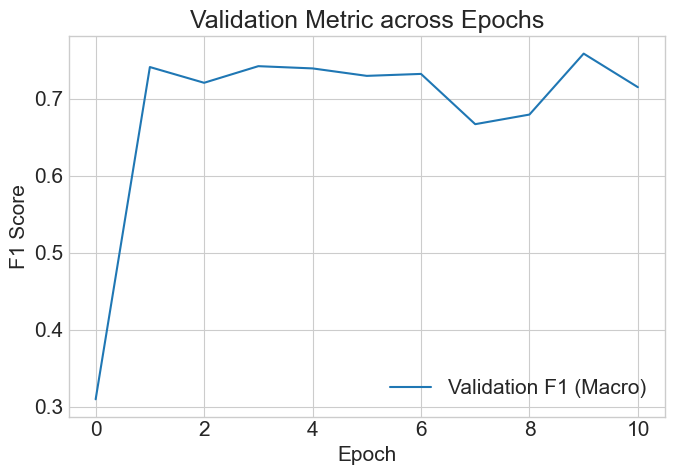

In [8]:
# Visualization — Plot validation curve
valid_key = 'valid' if 'valid' in metrics else ('eval' if 'eval' in metrics else None)
if valid_key is None:
	print("No validation metrics found for plotting.")
else:
	valid_df = pd.DataFrame(metrics[valid_key])
	plt.style.use('seaborn-v0_8-whitegrid')
	fig, ax = plt.subplots(1, 1, figsize=(7, 5))
	if 'f1_score' in valid_df.columns:
		sns.lineplot(data=valid_df, x=valid_df.index, y='f1_score', ax=ax, label='Validation F1 (Macro)')
		ax.set_ylabel('F1 Score')
	elif 'matthews_corrcoef' in valid_df.columns:
		sns.lineplot(data=valid_df, x=valid_df.index, y='matthews_corrcoef', ax=ax, label='Validation MCC')
		ax.set_ylabel('MCC')
	else:
		first_col = [c for c in valid_df.columns if isinstance(valid_df[c].iloc[-1], (int, float))]
		if first_col:
			sns.lineplot(data=valid_df, x=valid_df.index, y=first_col[0], ax=ax, label=first_col[0])
			ax.set_ylabel(first_col[0])
		else:
			print("Validation metrics exist but no numeric columns to plot.")
	ax.set_title('Validation Metric across Epochs')
	ax.set_xlabel('Epoch')
	ax.legend()
	plt.tight_layout()
	plt.show()

## References

- PlantRNA-FM: "An interpretable RNA foundation model for exploring functional RNA motifs in plants" (Nature Machine Intelligence, 2024).
